# Metrics for training + validation

In [26]:
#y_true = y_test
#y_pred = test_preds
#def dice_coef(y_true, y_pred, smooth=1):
#    y_true_f = K.flatten(y_true)
#    y_pred_f = K.flatten(y_pred)
#    intersection = K.sum(y_true_f * y_pred_f)
#    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


#def dice_coef_loss(y_true, y_pred):
#    return -dice_coef(y_true, y_pred)


#hi = y_test / 255
#hi = K.flatten(hi)
#hi = tf.convert_to_tensor(hi, dtype=None)
#pred = test_preds
#pred = K.flatten(pred)
#pred = tf.convert_to_tensor(test_preds, dtype=None)

def dice_coef(a, b):
          #  hi = K.hi
          #  hi = hi / 255
    
          #    hi = tf.convert_to_tensor(hi, dtype=None)
          #    pred = tf.convert_to_tensor(test_preds, dtype=None)
    hi = a
  #  hi = tf.dtypes.cast(hi, tf.float32)
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    upper_part = 2 * K.sum((hi * pred))
    lower_part = K.sum(hi + pred)
    dice = upper_part / lower_part
    return dice

def dice_coef_loss(a, b):
    loss = 1 - dice_coef(a, b)
    return loss

def jaccard_index(a, b):
    hi = a 
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    numerator = K.sum(hi * pred)
    denominator = K.sum((hi + pred) - (hi * pred))
    iou = numerator / denominator
    return iou

# Libraries

In [27]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Ternausnet

In [28]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19

"""
A Keras implementation of TernausNet16: 
https://arxiv.org/abs/1801.05746
https://github.com/ternaus/TernausNet
The architecture is very similar to the original U-net paper:
https://arxiv.org/abs/1505.04597
The key differences are:
- A VGG16 architecture is used for encoder, pretrained on ImageNet
- No batchnorm used
- No dropout used
- Shortcut concatenations are mismatched on number of filters meaning that 
  a larger number of filters is used in decoder.
"""


def decoder_block_ternausV2(inputs, mid_channels, out_channels):
    """
    Decoder block as proposed for TernausNet16 here: 
    https://arxiv.org/abs/1801.05746
    See DecoderBlockV2 here:
    https://github.com/ternaus/TernausNet/blob/master/unet_models.py
    - Concatenate u-net shortcut to input pre-upsample
    - Bilinear upsample input to double Height and Width dimensions
    - Note: The original ternausNet implementation includes option for 
      deconvolution instead of bilinear upsampling. Omitted here because I 
      couldn't find a meaningful performance comparison
    """
    
    conv_kwargs = dict(
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        data_format='channels_last'  # (batch, height, width, channels)
    )

    x = UpSampling2D(size=(2, 2))(inputs) # interpolation='bilinear' doesn't work?
    x = Conv2D(mid_channels, 3, **conv_kwargs)(x)
    x = Conv2D(out_channels, 3, **conv_kwargs)(x)
    return x


# INTENDED API
# ------------------------------------------------------------------------------

def ternausNet16(input_size=(256, 256, 3), output_channels=3):
    """
    A Keras implementation of TernausNet16: 
    https://arxiv.org/abs/1801.05746
    https://github.com/ternaus/TernausNet
    """

    # input 
    # convert 1 channel grayscale to 3 channels if needed
    inputs = Input(input_size)
    if input_size[-1] < 3:
        x = Conv2D(3, 1)(inputs)                         # add channels
        input_shape = (input_size[0], input_size[0], 3)  # update input size
    else:
        x = inputs
        input_shape = input_size
    
    # Load pretrained VGG, conv layers include relu activation
    encoder = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
       
    # (None, 256, 256, 3)
    e1 = encoder.get_layer(name='block1_conv1')(x)
    e1 = encoder.get_layer(name='block1_conv2')(e1)
    # (None, 256, 256, 64)
    e2 = MaxPooling2D(pool_size=(2, 2))(e1)
    e2 = encoder.get_layer(name='block2_conv1')(e2)
    e2 = encoder.get_layer(name='block2_conv2')(e2)
    # (None, 128, 128, 128)
    e3 = MaxPooling2D(pool_size=(2, 2))(e2)
    e3 = encoder.get_layer(name='block3_conv1')(e3)
    e3 = encoder.get_layer(name='block3_conv2')(e3)
    e3 = encoder.get_layer(name='block3_conv3')(e3)
    # (None, 64, 64, 256)
    e4 = MaxPooling2D(pool_size=(2, 2))(e3)
    e4 = encoder.get_layer(name='block4_conv1')(e4)
    e4 = encoder.get_layer(name='block4_conv2')(e4)
    e4 = encoder.get_layer(name='block4_conv3')(e4)
    # (None, 32, 32, 512)
    e5 = MaxPooling2D(pool_size=(2, 2))(e4)
    e5 = encoder.get_layer(name='block5_conv1')(e5)
    e5 = encoder.get_layer(name='block5_conv2')(e5)
    e5 = encoder.get_layer(name='block5_conv3')(e5)
    # (None, 16, 16, 512)
    center = MaxPooling2D(pool_size=(2, 2))(e5)
    # (None, 8, 8, 512)
    center = decoder_block_ternausV2(center, 512, 256)
    # (None, 16, 16, 256)
    d5 = concatenate([e5, center], axis=3)
    d5 = decoder_block_ternausV2(d5, 512, 256)
    # (None, 32, 32, 256)
    d4 = concatenate([e4, d5], axis=3)
    d4 = decoder_block_ternausV2(d4, 512, 128)
    # (None, 64, 64, 128)
    d3 = concatenate([e3, d4], axis=3)
    d3 = decoder_block_ternausV2(d3, 256, 64)
    # (None, 128, 128, 64)
    d2 = concatenate([e2, d3], axis=3)
    d2 = decoder_block_ternausV2(d2, 128, 64)
    # (None, 256, 256, 64)
    # Note: no decoder block used at end
    d1 = concatenate([e1, d2], axis=3)
    #initializer = tf.keras.initializers.LecunUniform()
    d1 = Conv2D(32, 3, padding='same', kernel_initializer='he_normal')(d1)
    #'he_normal'
    d1 = ReLU()(d1)
    # (None, 256, 256, 32)

    # Output
    #if output_channels > 1:
        # untested
    #    op = tf.nn.log_softmax_v2(d1, axis=3)
    #else:
        
    op = Conv2D(output_channels, 1)(d1)
    op = Activation('sigmoid')(op)  # note: ternaus excludes

    # Build
    model = Model(inputs=[inputs], outputs=[op])
    
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.5,
    staircase=True)
    
    opt = keras.optimizers.Adam(learning_rate=0.0001)

    #model.compile(optimizer='adam', loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[dice_coef, jaccard_index])
    
    return model

In [29]:
model = ternausNet16()

58892288/58889256 [==============================] - 0s 0us/step


In [30]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[1][0]               
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           block1_conv2[1][0]               
_______________________________________________________________________________________

# Training

In [31]:
print(x_train.shape)
print(y_train.shape)
filepath = "./model.h5"

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min' )
#mode='min'
callbacks_list = [checkpoint]
#earlystopper, 

history = model.fit(x_train, y_train, validation_split=0.2, batch_size=1, epochs=20, callbacks=callbacks_list)



(20, 256, 256, 3)
(20, 256, 256, 3)
Epoch 1/20
16/16 [==============================] - ETA: 0s - loss: -3825696256.0000 - dice_coef: 1.8757 - jaccard_index: 60.2431
Epoch 00001: val_loss improved from inf to -81642373120.00000, saving model to ./model.h5
16/16 [==============================] - 2s 129ms/step - loss: -3825696256.0000 - dice_coef: 1.8757 - jaccard_index: 60.2431 - val_loss: -81642373120.0000 - val_dice_coef: 1.9755 - val_jaccard_index: 89.3384
Epoch 2/20
16/16 [==============================] - ETA: 0s - loss: -2401448822308864.0000 - dice_coef: 1.9701 - jaccard_index: 70.9661
Epoch 00002: val_loss improved from -81642373120.00000 to -61988197831278592.00000, saving model to ./model.h5
16/16 [==============================] - 2s 111ms/step - loss: -2401448822308864.0000 - dice_coef: 1.9701 - jaccard_index: 70.9661 - val_loss: -61988197831278592.0000 - val_dice_coef: 1.9755 - val_jaccard_index: 89.3380
Epoch 3/20
16/16 [==============================] - ETA: 0s - loss: n

# Plotting history

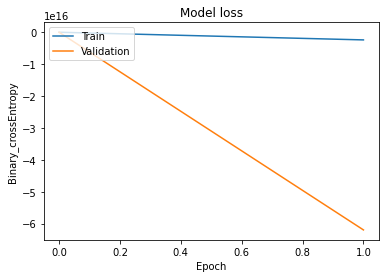

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

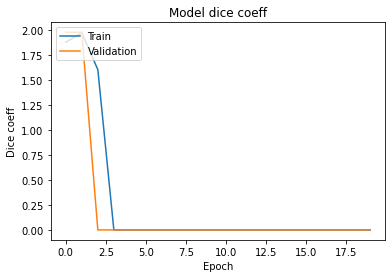

In [33]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model dice coeff')
plt.ylabel('Dice coeff')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

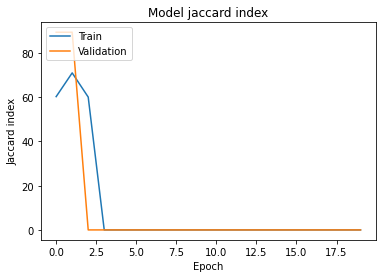

In [34]:
plt.plot(history.history['jaccard_index'])
plt.plot(history.history['val_jaccard_index'])
plt.title('Model jaccard index')
plt.ylabel('Jaccard index')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()